## Preparation

In [329]:
# Data Wrangling, Scraping and Visualizations  
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import random
import sqlite3
import re
import missingno as miss
import ipywidgets as widget 

# Data Management/Investigation
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import country_converter as coco
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.linear_model import ElasticNet as ENet 
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

## Data Wrangling and Constructing the Model Data Frame

In [2]:
## Connecting to a new SQLite Database to store all the data as different tables
conn = sqlite3.connect("Final_Project_Database.sqlite")

In [322]:
## Power plant data set 
## Reading in from csv file 
power_plant_data = pd.read_csv("Data/global_power_plant_database_v_1_3/global_power_plant_database.csv")

## Extracting columns of interest 
cols = ["country", "country_long", "name", "capacity_mw", "primary_fuel", "commissioning_year", "source", "generation_gwh_2013", "generation_gwh_2014", "generation_gwh_2015", "generation_gwh_2016", "generation_gwh_2017", "generation_gwh_2018", "generation_gwh_2019", "estimated_generation_gwh_2013", "estimated_generation_gwh_2014", "estimated_generation_gwh_2015", "estimated_generation_gwh_2016", "estimated_generation_gwh_2017"]
power_plant_data_final = power_plant_data.loc[:, cols]
#miss.matrix(power_plant_data_final)

In [324]:
## GHG emissions data set
## Reading in from csv file
historical_emissions_data = pd.read_csv("Data/historical_emissions/historical_emissions.csv")
#historical_emissions_data


In [326]:
## Countrywise GDP dataset
## Reading in from csv file
GDP_Data = pd.read_csv("Data/GDP_Data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_3358362.csv", skiprows = 4)
## Removing undesired columns 
GDP_Data = GDP_Data[GDP_Data.columns.difference(['Indicator Name', 'Indicator Code'])]
l = list(GDP_Data) ## Viewing the columns of the dataset 
del l[-3:] ## Deleting last three columns 
## Creating long format of data 
GDP_Data_final = pd.melt(GDP_Data, id_vars = ['Country Name', 'Country Code'], value_vars = l, var_name = 'Year', value_name = 'GDP_in_dollars')

#GDP_Data_final.sample(10)
#miss.matrix(GDP_Data_final)


In [ ]:
## Country wise Population data set
## Reading in from csv file
Population_Growth_data = pd.read_csv("Data/Population_Growth/API_SP.POP.GROW_DS2_en_csv_v2_3159088.csv", skiprows = 4)
## Removing undesired columns 
Pop_Growth = Population_Growth_data[Population_Growth_data.columns.difference(['Indicator Name', 'Indicator Code'])]
l = list(Pop_Growth)  ## Viewing the columns of the dataset 
del l[-3:]  ## Deleting last three columns 
## Creating long format of data 
Pop_Growth = pd.melt(Pop_Growth, id_vars = ['Country Name', 'Country Code'], value_vars = l, var_name = 'Year', value_name = 'Population_Growth')
#Pop_Growth.sample(10)

## Reading in from csv file
Population_Data = pd.read_csv("Data/Population_Data/API_SP.POP.TOTL_DS2_en_csv_v2_3358390.csv", skiprows = 4)
## Removing undesired columns 
Population_Data_Final = Population_Data[Population_Data.columns.difference(['Indicator Name', 'Indicator Code'])]
l = list(Population_Data_Final)  ## Viewing the columns of the dataset 
del l[-3:]  ## Deleting last three columns 
## Creating long format of data 
Population_Data_Final = pd.melt(Population_Data_Final, id_vars = ['Country Name', 'Country Code'], value_vars = l, var_name = 'Year', value_name = 'Population')
#Population_Data_Final.sample(10)

## Merging the two tables 
Population_Data_Final = pd.merge(Population_Data_Final, Pop_Growth, how = 'left', on = ['Country Name', 'Country Code', 'Year'])

##Population_Data_Final.sample(10)
##miss.matrix(Population_Data_Final)

In [ ]:
## Democracy indices data set 
Democracy_Index_Data = pd.read_csv("Data/Country_Year_V-Dem_Core_CSV_v11.1/V-Dem-CY-Core-v11.1.csv")

#Democracy_Index_Data.sample(20)

### Extracting only required columns 
Democracy_Index_Data_Final = Democracy_Index_Data.loc[:, ['country_name', 'year', 'v2x_polyarchy', 'v2x_libdem', 'v2x_partipdem', 'v2x_delibdem', 'v2x_egaldem']]
## Only for years greater than 2013
Democracy_Index_Data_Final = Democracy_Index_Data_Final[Democracy_Index_Data_Final.year > 2013]
## Renaming column names to something meaningful 
Democracy_Index_Data_Final = Democracy_Index_Data_Final.rename(columns = {'v2x_polyarch' : 'Electoral_Democracy', 'v2x_libdem': 'Liberal_Democracy', 'v2x_partipdem' : 'Participatory_Democracy', 'v2x_delibdem' : 'Deliberative_Democracy', 'v2x_egaldem' : 'Egalitarian_Democracy'})

##Democracy_Index_Data_Final.sample(20)
##miss.matrix(Democracy_Index_Data_Final)

In [ ]:
## Protected Areas data set 
## Reading in CSV file 
protected_areas_data = pd.read_csv("Data/WDPA_WDOECM_Oct2021_Public_all_csv/WDPA_WDOECM_Oct2021_Public_all_csv.csv")

## Since only the ISO3 code is present in the data set and not the actual country name
## The ISO3 codes and the corresponding names were scrapped off a website and added to final data set 
## The website URL has unfortunately changed so running the code given below will produce an error 
## But I have included the original code I used to scrape off the website
## Since all these data sets were being stored in an SQL Database, the code needed to be run only once

## Scraping the website for country codes 

Country_Code = None
page = requests.get("https://unstats.un.org/unsd/tradekb/knowledgebase/country-code")
soup = BeautifulSoup(page.content, 'html.parser')
codes = soup.find_all('div', class_ = "row article margin-top")
for tag in codes :
    Country_Code = tag.text
    

## Using regular expressions to isolate the reqired element     
x = re.split('[\\r\\n]', Country_Code)
ccodes = [] ## Initializing empty list 
for element in x :
    if element == '' :
        continue
    elif re.match('[A-Z]{3}', element) :
        ccodes.append(element)

ccodes.pop(0) ## Removing the line starting with ISO   

## Further processing to extract country name 
ccode_list = []
for ccode in ccodes : 
    ccode_list.append(ccode.split(' ', 1))

    
## Initializing dataframe 
Country_WDPA = pd.DataFrame()

for ccode in ccode_list :
    Country_WDPA = Country_WDPA.append({'ISO3' : ccode[0], 'Country' : ccode[1]}, ignore_index=True)
    
    
## Merging onto the original data frame after extracting required columns 
protected_area_final = protected_areas_data.filter(["WDPAID", "NAME", "DESIG", "DESIG_TYPE", "STATUS", "STATUS_YR", "REP_AREA", "ISO3"])
protected_area_final = pd.merge(protected_area_final, Country_WDPA, how = 'left', on = 'ISO3')

#protected_area_final

In [ ]:
## Writing all the data frames created above to SQLite Database 
GDP_Data_final.to_sql(name = 'GDP_Data', con = conn, index = False)
power_plant_data_final.to_sql(name = 'Global_Power_Plants', con = conn, index = False) 
historical_emissions_data.to_sql(name = "CO2_Historical_Emissions_Data", con = conn, index = False)
Democracy_Index_Data_Final.to_sql(name = "Democracy_Index", con = conn, index = False) 
Population_Data_Final.to_sql(name = 'Population_by_Country', con = conn, index = False)
protected_area_final.to_sql(name = 'Protected_Areas', con = conn, index = False) 

### Creating visualizations on the obtained data 

In [327]:
## Reading in the protected areas table from SQLite database and storing in a data frame 
df_protected_areas = pd.read_sql_query("SELECT * from Final_Protected_Areas", con = conn)
df_protected_areas.sample(10)

,WDPAID,NAME,DESIG,DESIG_TYPE,STATUS,STATUS_YR,ISO3,Country,REP_AREA
4638,541,Coopracambra,National Park,National,Designated,1991,AUS,Australia,385.022213
6255,7054,Erpeler Ley,Naturschutzgebiet,National,Designated,1941,DEU,Germany,0.085500
671,29484,Diécké,Classified Forest,National,Designated,1945,GIN,Guinea,640.000000
8785,6937,Morne Seychellois National Park,National Park,National,Designated,1979,SYC,Seychelles,31.294720
7777,31551,Dzūkijos Nacionalinis Parkas,Valstybinis Parkas,National,Designated,1991,LTU,Lithuania,583.572000
1274,3281,Horton Plains,National Park,National,Designated,1988,LKA,Sri Lanka,31.598000
9938,13023,Blackwater National Wildlife Refuge,Marine Protected Area,National,Designated,1933,USA,United States,115.780935
7396,9598,Kállósemjéni Mohos-Tó Természetvédelmi Terület,Természetvédelmi Terület,National,Designated,1954,HUN,Hungary,0.950321
2557,18779,Bell Sound,Nature Reserve,National,Designated,1975,TCA,Turks and Caicos Islands,11.420000
1857,36333,Rakuma,Forest Reserve,National,Designated,0,NGA,Nigeria,0.000000


In [330]:
## Plotting an interactive graph to visualize the increase in protected areas for a particular country 
def plot_increase_country(country = "Italy") :
    """
    Function to plot the increase in protected areas over time in a particular country
    
    Arguments : 
    ~~~~~~~~~~~~~~
    country : The country whose graph is to be generated 
    
    Returns :
    ~~~~~~~~~~~~~
    NULL 
    
    """
    ## Getting the data of only the country 
    df_country = df_protected_areas.loc[(df_protected_areas.Country == country) & ((df_protected_areas.STATUS.str.strip() == "Designated") | (df_protected_areas.STATUS.str.strip() == "Inscribed")) & (df_protected_areas.STATUS_YR != 0)] 
    ## Extracting required columns 
    df_country = (df_country.filter(["STATUS_YR", "REP_AREA"]) 
                  .sort_values(["STATUS_YR"]) ## Sorting by year
                  .groupby(["STATUS_YR"]) ## Grouping by year
                  .sum() ## Summing over the area 
                  .reset_index()) ## Resetting the index
    
    area_increase = df_country[['REP_AREA']].cumsum() ## Calculating cummulative sum over the years 
    df_country["Area_Increase"] = area_increase ## Creating new column

    ## Plotting 
    x_ax = df_country["STATUS_YR"] ## x-axis
    y_ax = df_country["Area_Increase"] ## y-axis 
    plt.figure(figsize = (8,10))
    plt.plot(x_ax, y_ax, color = 'red')
    plt.show()
    
## Setting the list to be passed to the interact function
country_list = df_protected_areas["Country"] ## Selecting required column
country_list = set(country_list) ## Getting unique values
country_list = list(country_list) ## Converting back to list
country_list = [i for i in country_list if i] ## Removing null values
country_list.sort() ## Sorting list alphabetically 

plot_country = widget.interact(plot_increase_country, country = country_list)



interactive(children=(Dropdown(description='country', options=('Afghanistan ', 'Albania ', 'Algeria ', 'Americ…

### Constructing the final Model Data Set 

In [6]:
## Getting the country converter to ensure uniform country names 
cc = coco.CountryConverter() 

In [331]:
## Getting the outcome variable from respective dataset
CO2_data = pd.read_sql("SELECT * FROM CO2_Historical_Emissions_Data", con = conn)
## Getting only relevant columns for year 2016 
CO2_data = CO2_data[['Country', 'Unit', 'Gas', '2016']]

## Only extracting emissions for CO2 gas
CO2_data = CO2_data[CO2_data.Gas == 'CO2']
CO2_data = CO2_data.rename(columns = {'2016' : 'Emissions'})
CO2_data['Country'] = cc.convert(names = CO2_data['Country'], to = 'name_short') ## Coverting country names to single format
CO2_data = CO2_data[CO2_data.Country != 'not found']

#CO2_data


World not found in regex
European Union (27) not found in regex


In [316]:
## Extracting table from database and storing as data frame  
Power_Plant_data = pd.read_sql_query("SELECT country_long, capacity_mw, primary_fuel, commissioning_year \
                                     FROM Global_Power_Plants", con = conn)

## Filling NAs with 0 for commissioning year to not omit observations when applying the year criteria
Power_Plant_data.commissioning_year = Power_Plant_data.commissioning_year.fillna(0)
Power_Plant_data = Power_Plant_data.loc[Power_Plant_data.commissioning_year <= 2016]


Power_Plant_data = (Power_Plant_data.rename(columns = {'country_long' : 'Country'})
                    .drop(columns = ["commissioning_year"])
                    .groupby(["Country", "primary_fuel"])
                    .sum()
                    .reset_index())

Power_Plant_data = pd.pivot_table(Power_Plant_data, values = "capacity_mw", index = "Country", columns = "primary_fuel", fill_value = 0)
Power_Plant_data = Power_Plant_data.reset_index()
Power_Plant_data = Power_Plant_data.rename(columns = {'Gas' : 'Natural_Gas'})
Power_Plant_data = Power_Plant_data[["Country", "Coal", "Natural_Gas", "Hydro", "Nuclear", "Solar", "Wind"]]

## Converting country names to common format 
Power_Plant_data['Country'] = cc.convert(names = Power_Plant_data['Country'], to = 'name_short') ## Coverting country names to single format
Power_Plant_data = Power_Plant_data[Power_Plant_data.Country != 'not found']

Power_Plant_data


primary_fuel,Country,Coal,Natural_Gas,Hydro,Nuclear,Solar,Wind
0,Afghanistan,0.0,42.00,238.55,0.0,20.0,0.0
1,Albania,0.0,0.00,1431.00,0.0,0.0,0.0
2,Algeria,0.0,15179.00,24.00,0.0,670.8,0.0
3,Angola,0.0,163.68,770.60,0.0,0.0,0.0
4,Antarctica,0.0,0.00,0.00,0.0,0.0,1.0
...,...,...,...,...,...,...,...
162,Vietnam,13525.0,7734.00,16750.09,0.0,1616.4,135.0
163,Western Sahara,0.0,0.00,0.00,0.0,0.0,0.0
164,Yemen,0.0,400.00,0.00,0.0,0.0,0.0
165,Zambia,300.0,0.00,2160.00,0.0,47.5,0.0


In [9]:
## For year 2016, and indicator for Liberal Democracy 
Dem_Index_data = (pd.read_sql("SELECT country_name, year, Liberal_Democracy, Participatory_Democracy FROM Democracy_Index WHERE year == 2016", con = conn)
                  .drop(columns = ['year'])
                  .rename(columns = {'country_name' : 'Country'}))

Dem_Index_data['Country'] = cc.convert(names = Dem_Index_data['Country'], to = 'name_short') ## Coverting country names to single format
Dem_Index_data = Dem_Index_data[Dem_Index_data.Country != 'not found']
Dem_Index_data



Zanzibar not found in regex


,Country,Liberal_Democracy,Participatory_Democracy
0,Mexico,0.423,0.388
1,Suriname,0.650,0.490
2,Sweden,0.882,0.657
3,Switzerland,0.849,0.794
4,Ghana,0.602,0.371
...,...,...,...
173,Slovenia,0.801,0.689
174,Solomon Islands,0.448,0.337
175,Vanuatu,0.649,0.462
176,United Arab Emirates,0.091,0.033


In [10]:
## For year 2016 and population and population growth
Population_data = (pd.read_sql("SELECT * FROM Population_by_Country WHERE Year == 2016", con = conn)
                   .drop(columns = ['Year', 'Country Code'])
                   .rename(columns = {'Country Name' : 'Country'}))

Population_data['Country'] = cc.convert(names = Population_data['Country'], to = 'name_short') ## Coverting country names to single format
Population_data = Population_data[Population_data.Country != 'not found']


Population_data


Africa Eastern and Southern not found in regex
Africa Western and Central not found in regex
Arab World not found in regex
Central Europe and the Baltics not found in regex
Channel Islands not found in regex
Caribbean small states not found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
High income not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not fo

,Country,Population,Population_Growth
0,Aruba,104865.0,0.502860
2,Afghanistan,35383028.0,2.778035
4,Angola,28842482.0,3.378269
5,Albania,2876101.0,-0.159880
6,Andorra,77295.0,-0.898981
...,...,...,...
261,Kosovo,1777557.0,-0.596734
262,Yemen,27168210.0,2.498277
263,South Africa,56207649.0,1.471933
264,Zambia,16363449.0,3.002935


In [11]:
## Pulling in GDP data from the database
GDP_data = (pd.read_sql("SELECT * FROM GDP_Data WHERE Year == 2016", con = conn)
           .drop(columns = ['Year', 'Country Code'])
           .rename(columns = {'Country Name' : 'Country'}))

GDP_data['Country'] = cc.convert(names = GDP_data['Country'], to = 'name_short') ## Coverting country names to single format
GDP_data = GDP_data[GDP_data.Country != 'not found']

GDP_data

Africa Eastern and Southern not found in regex
Africa Western and Central not found in regex
Arab World not found in regex
Central Europe and the Baltics not found in regex
Channel Islands not found in regex
Caribbean small states not found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
High income not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not fo

,Country,GDP_in_dollars
0,Aruba,2.983637e+09
2,Afghanistan,1.801775e+10
4,Angola,1.011239e+11
5,Albania,1.186120e+10
6,Andorra,2.896679e+09
...,...,...
261,Kosovo,6.719172e+09
262,Yemen,3.093383e+10
263,South Africa,2.963573e+11
264,Zambia,2.095841e+10


In [6]:
## Energy Consumption Data extracting columns to add to final dataset 
Energy_Consumption_data = (pd.read_csv("Data/primary-energy-cons.csv") 
                          .drop(columns = ['Code'])
                          .rename(columns = {'Entity' : 'Country', 'Primary energy consumption (TWh)' : 'Energy_consumption'}))

Energy_Consumption_data = Energy_Consumption_data.loc[Energy_Consumption_data.Year == 2016]
Energy_Consumption_data['Country'] = cc.convert(names = Energy_Consumption_data['Country'], to = 'name_short') ## Coverting country names to single format
Energy_Consumption_data = Energy_Consumption_data[Energy_Consumption_data.Country != 'not found']

Energy_Consumption_data = Energy_Consumption_data.drop(columns = ['Year'])

Energy_Consumption_data


Africa not found in regex
Asia Pacific not found in regex
CIS not found in ISO3
Central America not found in regex
Eastern Africa not found in regex
Europe not found in regex
Europe (other) not found in regex
Middle Africa not found in regex
Middle East not found in regex
Netherlands Antilles not found in regex
North America not found in regex
OPEC not found in regex
Other Asia & Pacific not found in regex
Other CIS not found in regex
Other Caribbean not found in regex
Other Middle East not found in regex
Other Northern Africa not found in regex
Other South America not found in regex
South & Central America not found in regex
Timor not found in regex
United States Pacific Islands not found in regex
Western Africa not found in regex
World not found in regex


,Country,Energy_consumption
36,Afghanistan,35.737
128,Albania,39.446
180,Algeria,616.819
220,American Samoa,1.464
257,Angola,104.001
...,...,...
9860,Vietnam,864.015
9955,Western Sahara,1.068
10047,Yemen,68.604
10096,Zambia,46.347


In [7]:
## Whether NDC was ratified
NDC_data = (pd.read_csv("Data/ndc_content/ndc_content.csv")
            .rename(columns = {'Value' : 'Ratified'}))
        
NDC_data = NDC_data[['Country', 'Indicator name', 'Ratified']] ## Extracting only relevant values 
NDC_data['Country'] = cc.convert(names = NDC_data['Country'], to = 'name_short')
NDC_data = NDC_data[NDC_data.Country != 'not found']
NDC_data = NDC_data.loc[NDC_data['Indicator name'] == 'Ratified'] ## Whether it was ratified
NDC_data = NDC_data.drop(columns = ['Indicator name'])
NDC_data

European Union (27) not found in regex
European Union (27) not found in regex
European Union (27) not found in regex
European Union (27) not found in regex
European Union (27) not found in regex
European Union (27) not found in regex
European Union (27) not found in regex
European Union (27) not found in regex
European Union (27) not found in regex


,Country,Ratified
0,Afghanistan,Yes
9,Albania,Yes
18,Algeria,Yes
27,Andorra,Yes
36,Angola,Yes
...,...,...
1720,Venezuela,Yes
1729,Vietnam,Yes
1738,Yemen,No
1746,Zambia,Yes


In [40]:
## For year 2016 Land area data  
Land_Area_data = (pd.read_csv("Data/Total_Area/API_AG.LND.TOTL.K2_DS2_en_csv_v2_3359379.csv", skiprows = 4)
                   .filter(["Country Name", "2016"])
                   .rename(columns = {'Country Name' : 'Country', '2016' : 'Total_Area'}))

Land_Area_data['Country'] = cc.convert(names = Land_Area_data['Country'], to = 'name_short') ## Coverting country names to single format
Land_Area_data = Land_Area_data[Land_Area_data.Country != 'not found']


#Land_Area_data



Africa Eastern and Southern not found in regex
Africa Western and Central not found in regex
Arab World not found in regex
Central Europe and the Baltics not found in regex
Channel Islands not found in regex
Caribbean small states not found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
High income not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not fo

,Country,Total_Area
0,Aruba,180.0
2,Afghanistan,652860.0
4,Angola,1246700.0
5,Albania,27400.0
6,Andorra,470.0
...,...,...
261,Kosovo,10887.0
262,Yemen,527970.0
263,South Africa,1213090.0
264,Zambia,743390.0


In [62]:
## Getting protected area data 
protected_area_data = pd.read_sql_query("SELECT * FROM Final_Protected_Areas", con = conn)
protected_area_data = protected_area_data.loc[((protected_area_data.STATUS.str.strip() == "Designated") | (protected_area_data.STATUS.str.strip() == "Inscribed")) & (protected_area_data.STATUS_YR <= 2016)]

protected_area_data = (protected_area_data.filter(['Country', 'REP_AREA'])
                       .groupby(['Country'])
                       .sum()
                       .reset_index()
                       .rename(columns = {'REP_AREA' : 'Protected_Area'}))

protected_area_data['Country'] = cc.convert(names = protected_area_data['Country'], to = 'name_short') ## Coverting country names to single format
protected_area_data = protected_area_data[protected_area_data.Country != 'not found']


## Merging tables to calculate the percentage of area classified as protected                        
protected_area_data = pd.merge(protected_area_data, Land_Area_data, how = 'left', on = 'Country')

protected_area_data['Percentage_of_Area'] = protected_area_data.Protected_Area/protected_area_data.Total_Area*100

protected_area_data



Congo  not found in regex


,Country,Protected_Area,Total_Area,Percentage_of_Area
0,Afghanistan,606.160807,652860.0,0.092847
1,Albania,1128.632000,27400.0,4.119095
2,Algeria,918244.740000,2381741.0,38.553509
3,American Samoa,6.749747,200.0,3.374874
4,Andorra,0.000000,470.0,0.000000
...,...,...,...,...
182,Vietnam,10458.962000,310070.0,3.373097
183,British Virgin Islands,5.468014,150.0,3.645343
184,United States Virgin Islands,136.583466,350.0,39.023847
185,Zambia,287480.004300,743390.0,38.671492


<font size = 3 face = "Verdana">
    <p> The dataset to be used for modelling is displayed below. The <b>outcome variable</b> is denoted by <b>Emissions</b>. Since the <b>unit of analysis</b> is <b>Country</b>, the dataset has a relatively small sample size.  

In [318]:
### Merging all the above the datasets to create the final data set 
Model_data = pd.merge(Dem_Index_data, GDP_data, how = 'left', on = ['Country'])
Model_data = pd.merge(Model_data, Population_data, how = 'left', on = ['Country'])
Model_data = pd.merge(Model_data, CO2_data, how = 'left', on = ['Country'])
Model_data = pd.merge(Model_data, Energy_Consumption_data, how = 'left', on = ['Country'])
Model_data = pd.merge(Model_data, NDC_data, how = 'left', on = ['Country'])
Model_data = pd.merge(Model_data, protected_area_data, how = 'left', on = 'Country')
Model_data = pd.merge(Model_data, Power_Plant_data, how = 'left', on = 'Country')
Model_data

,Country,Liberal_Democracy,Participatory_Democracy,GDP_in_dollars,Population,Population_Growth,Unit,Gas,Emissions,Energy_consumption,...,ln_GDP,ln_Population,ln_Energy,ln_protected_area,Coal,Natural_Gas,Hydro,Nuclear,Solar,Wind
0,Mexico,0.423,0.388,1.078491e+12,123333379.0,1.203260,MtCO₂e,CO2,1.974630,2162.618,...,27.706584,18.630402,7.679537,1.082536,5378.4,25674.2,12442.9,1510.0,2671.2,1586.8
1,Suriname,0.650,0.490,3.317439e+09,564883.0,1.022589,MtCO₂e,CO2,1.263911,11.562,...,21.922459,13.244376,2.530676,1.396979,0.0,0.0,0.0,0.0,5.0,0.0
2,Sweden,0.882,0.657,5.156547e+11,9923085.0,1.256454,MtCO₂e,CO2,1.421073,594.882,...,26.968703,16.110375,6.390043,1.144306,80.0,1340.0,12822.9,9762.0,0.0,697.1
3,Switzerland,0.849,0.794,6.956007e+11,8373338.0,1.092031,MtCO₂e,CO2,1.536281,307.959,...,27.268042,15.940563,5.733209,1.646649,0.0,0.0,9667.8,3430.0,20.2,0.0
4,Ghana,0.602,0.371,5.449945e+10,28481947.0,2.246610,MtCO₂e,CO2,NaN,77.037,...,24.721456,17.164781,4.357183,2.137812,0.0,490.0,1598.0,0.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Slovenia,0.801,0.689,4.473633e+10,2065042.0,0.073197,MtCO₂e,CO2,1.315306,78.705,...,24.524052,14.540662,4.378332,1.678515,1321.0,297.0,422.0,696.0,0.0,0.0
175,Solomon Islands,0.448,0.337,1.378551e+09,619438.0,2.667488,MtCO₂e,CO2,1.577997,0.971,...,21.044299,13.336570,0.678541,0.472568,NaN,NaN,NaN,NaN,NaN,NaN
176,Vanuatu,0.649,0.462,7.808896e+08,278326.0,2.620205,MtCO₂e,CO2,0.153163,0.699,...,20.475944,12.536552,0.530040,0.246911,NaN,NaN,NaN,NaN,NaN,NaN
177,United Arab Emirates,0.091,0.033,3.570451e+11,9360975.0,1.053271,MtCO₂e,CO2,1.840647,1293.926,...,26.601128,16.052060,7.166209,0.000000,0.0,29487.0,0.0,0.0,840.0,0.0


In [65]:
## Replacing NA values for protected areas columns with 0
Model_data['Percentage_of_Area'] = Model_data['Percentage_of_Area'].fillna(0)

In [319]:
## Writing to SQLite
Model_data.to_sql(name = "Model_Data", con = conn, index = False)

# Exploratory Data Analysis

<h2>Exploring the data</h2><br><br>
<font size = 3 face = "Verdana">
    <p> The missing values are visualized and dropped</p>

In [333]:
## Reading in the data from SQL database
Model_data = pd.read_sql_query("SELECT * FROM Model_Data ", con = conn)
Model_data

,Country,Liberal_Democracy,Participatory_Democracy,GDP_in_dollars,Population,Population_Growth,Unit,Gas,Emissions,Energy_consumption,...,ln_GDP,ln_Population,ln_Energy,ln_protected_area,Coal,Natural_Gas,Hydro,Nuclear,Solar,Wind
0,Mexico,0.423,0.388,1.078491e+12,123333379.0,1.203260,MtCO₂e,CO2,1.974630,2162.618,...,27.706584,18.630402,7.679537,1.082536,5378.4,25674.2,12442.9,1510.0,2671.2,1586.8
1,Suriname,0.650,0.490,3.317439e+09,564883.0,1.022589,MtCO₂e,CO2,1.263911,11.562,...,21.922459,13.244376,2.530676,1.396979,0.0,0.0,0.0,0.0,5.0,0.0
2,Sweden,0.882,0.657,5.156547e+11,9923085.0,1.256454,MtCO₂e,CO2,1.421073,594.882,...,26.968703,16.110375,6.390043,1.144306,80.0,1340.0,12822.9,9762.0,0.0,697.1
3,Switzerland,0.849,0.794,6.956007e+11,8373338.0,1.092031,MtCO₂e,CO2,1.536281,307.959,...,27.268042,15.940563,5.733209,1.646649,0.0,0.0,9667.8,3430.0,20.2,0.0
4,Ghana,0.602,0.371,5.449945e+10,28481947.0,2.246610,MtCO₂e,CO2,NaN,77.037,...,24.721456,17.164781,4.357183,2.137812,0.0,490.0,1598.0,0.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Slovenia,0.801,0.689,4.473633e+10,2065042.0,0.073197,MtCO₂e,CO2,1.315306,78.705,...,24.524052,14.540662,4.378332,1.678515,1321.0,297.0,422.0,696.0,0.0,0.0
175,Solomon Islands,0.448,0.337,1.378551e+09,619438.0,2.667488,MtCO₂e,CO2,1.577997,0.971,...,21.044299,13.336570,0.678541,0.472568,NaN,NaN,NaN,NaN,NaN,NaN
176,Vanuatu,0.649,0.462,7.808896e+08,278326.0,2.620205,MtCO₂e,CO2,0.153163,0.699,...,20.475944,12.536552,0.530040,0.246911,NaN,NaN,NaN,NaN,NaN,NaN
177,United Arab Emirates,0.091,0.033,3.570451e+11,9360975.0,1.053271,MtCO₂e,CO2,1.840647,1293.926,...,26.601128,16.052060,7.166209,0.000000,0.0,29487.0,0.0,0.0,840.0,0.0


In [337]:
## The dataset is split into training and test 
y = Model_data['Emissions']
X = Model_data[['Liberal_Democracy', 'Population_Growth', 'GDP_in_dollars', 'Population', 'Energy_consumption', 'Ratified', 'Percentage_of_Area', 'Coal', 'Hydro', 'Natural_Gas']]

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1998)

<AxesSubplot:>

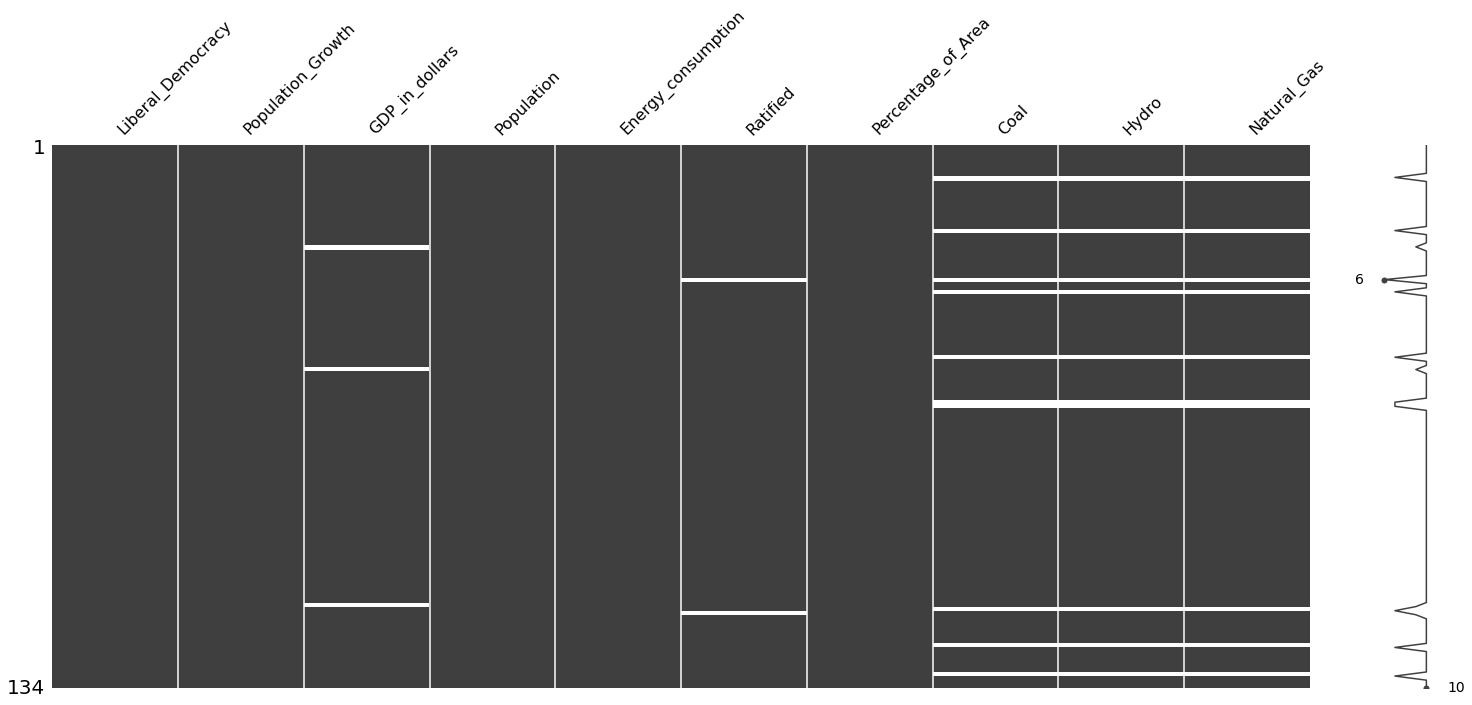

In [338]:
miss.matrix(train_X) ## Visualizing the missing values 

In [364]:
## Dropping the missing values 
df = train_X.dropna()

In [341]:
## Converting Ratified to category for plotting 
df['Ratified'] = df['Ratified'].astype('category')

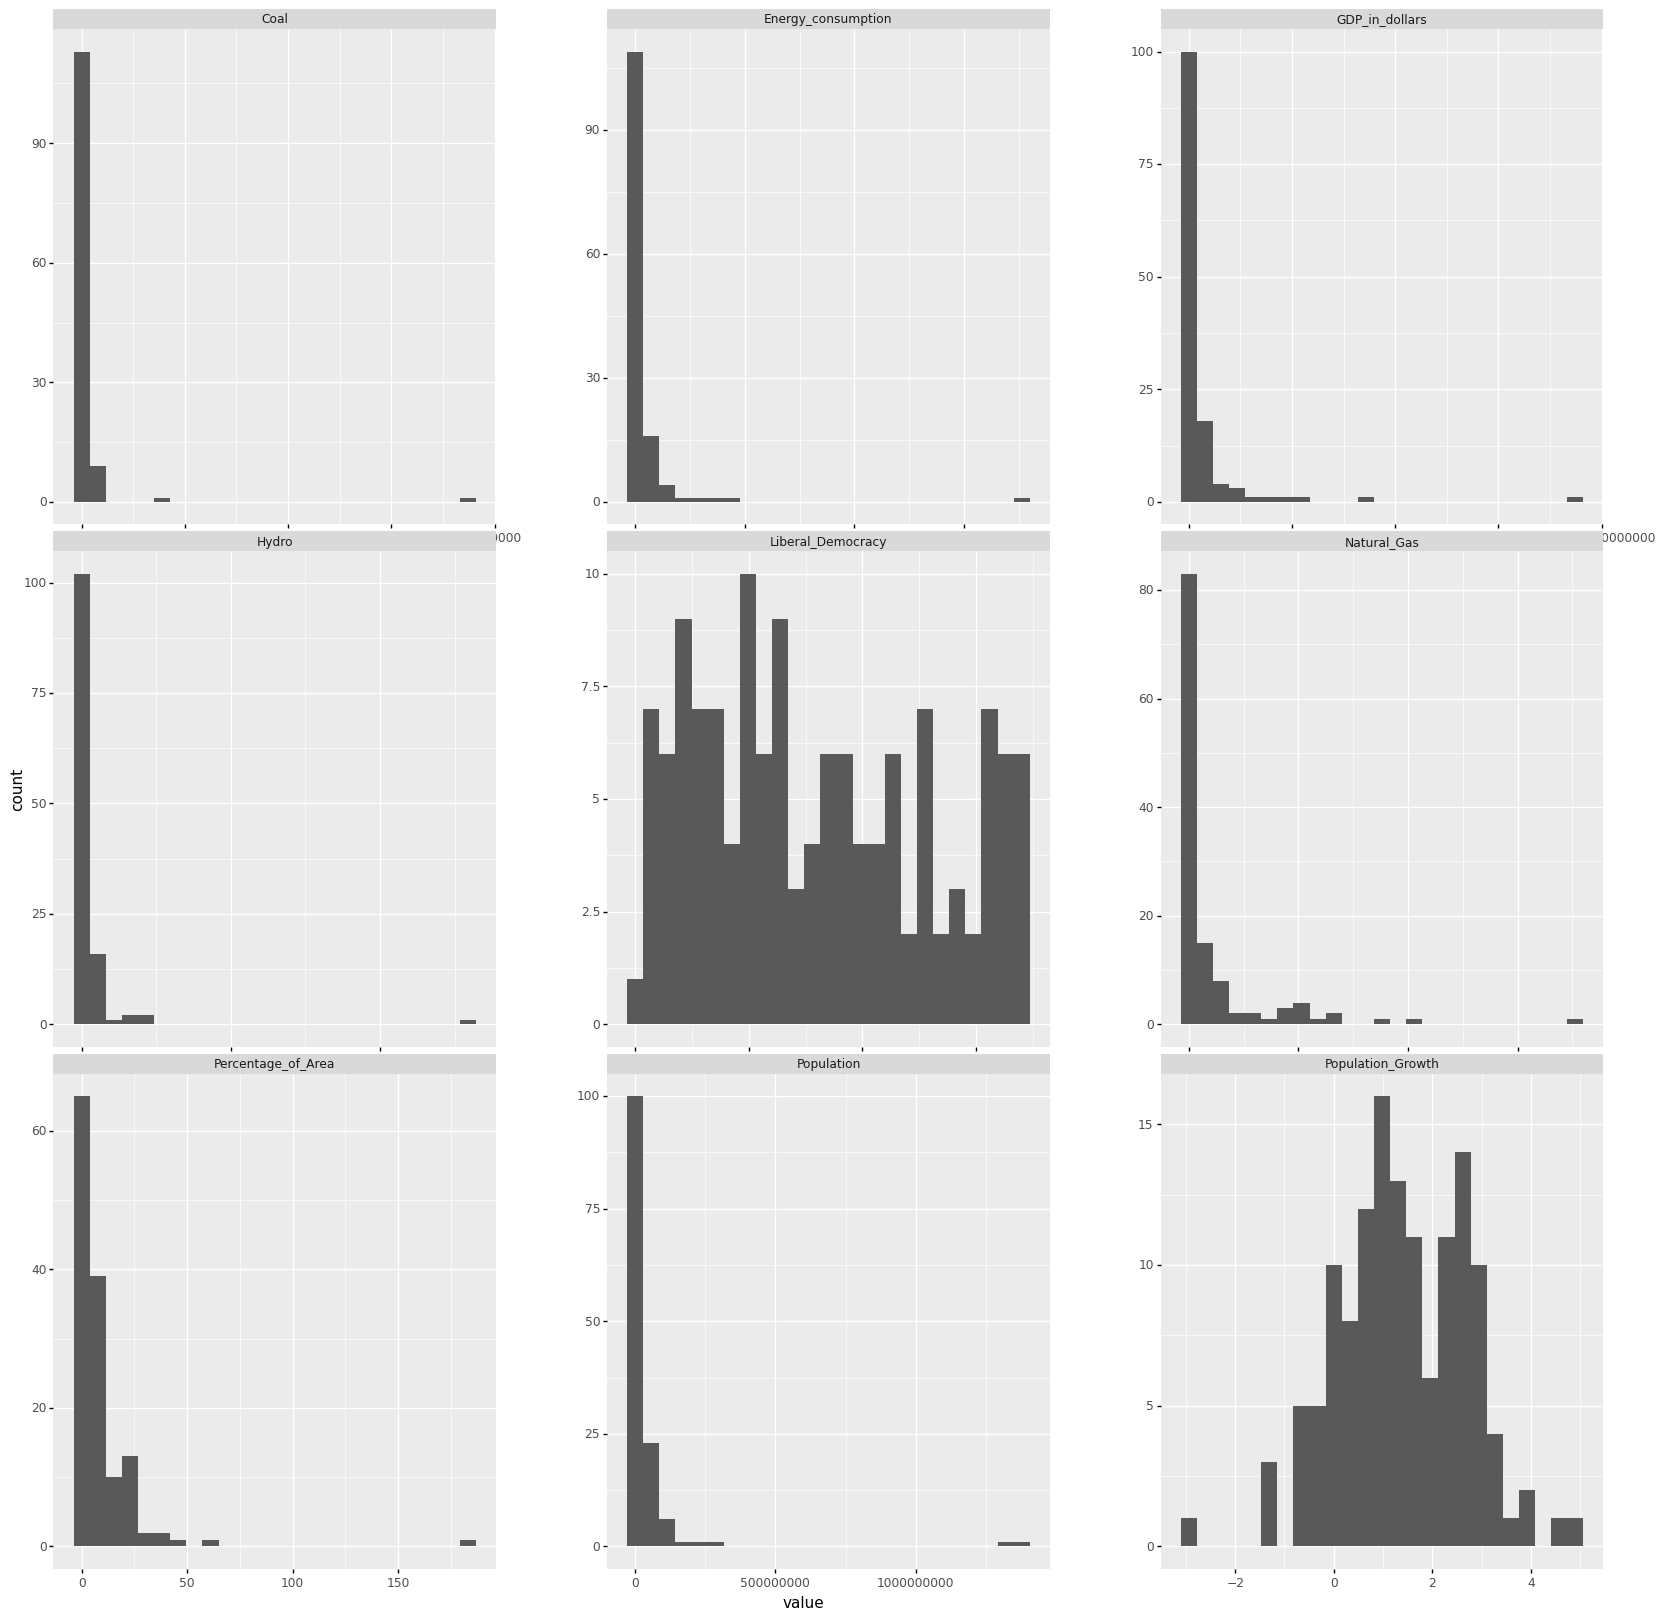

<ggplot: (364652629)>

In [340]:
# Plot the continuous Variables 
d = train_X.select_dtypes(include="float").melt()
(ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(20,20),
          subplots_adjust={'wspace':0.25}))

Many of the variables are skewed to the left. Log the variables and observe. 

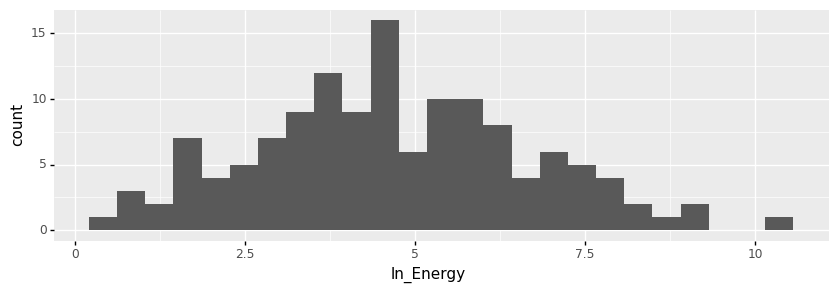

<ggplot: (367959306)>

In [110]:
## Logging the variables and plotting 
d = train_X.copy()
d['ln_Energy'] =  np.log(d['Energy_consumption'] + 1)
(
    ggplot(d,aes(x="ln_Energy")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

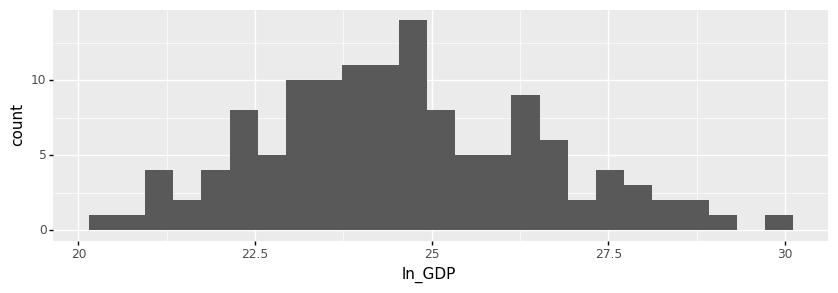

<ggplot: (365251063)>

In [111]:
d = df.copy()
d['ln_GDP'] =  np.log(d['GDP_in_dollars'] + 1)
(
    ggplot(d,aes(x="ln_GDP")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

## Since the distribution has become normal, we have to log GDP 

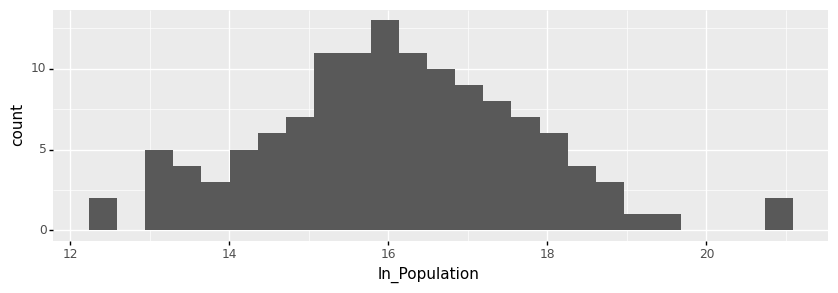

<ggplot: (368114267)>

In [112]:
d = df.copy()
d['ln_Population'] =  np.log(d['Population'] + 1)
(
    ggplot(d,aes(x="ln_Population")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

## Since the distribution has become normal, we have log Population

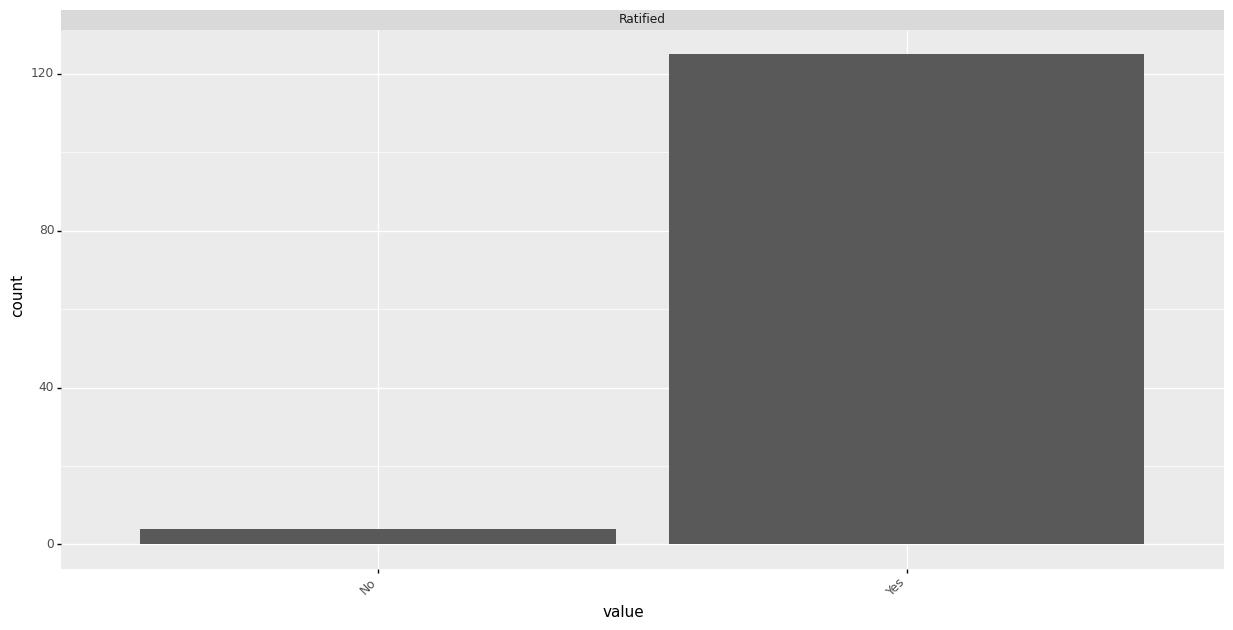

<ggplot: (368064835)>

In [113]:
## Plotting Ratified 
d = df.select_dtypes(include="category").melt()
(
    ggplot(d,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

# Pre-processing the data 

<AxesSubplot:>

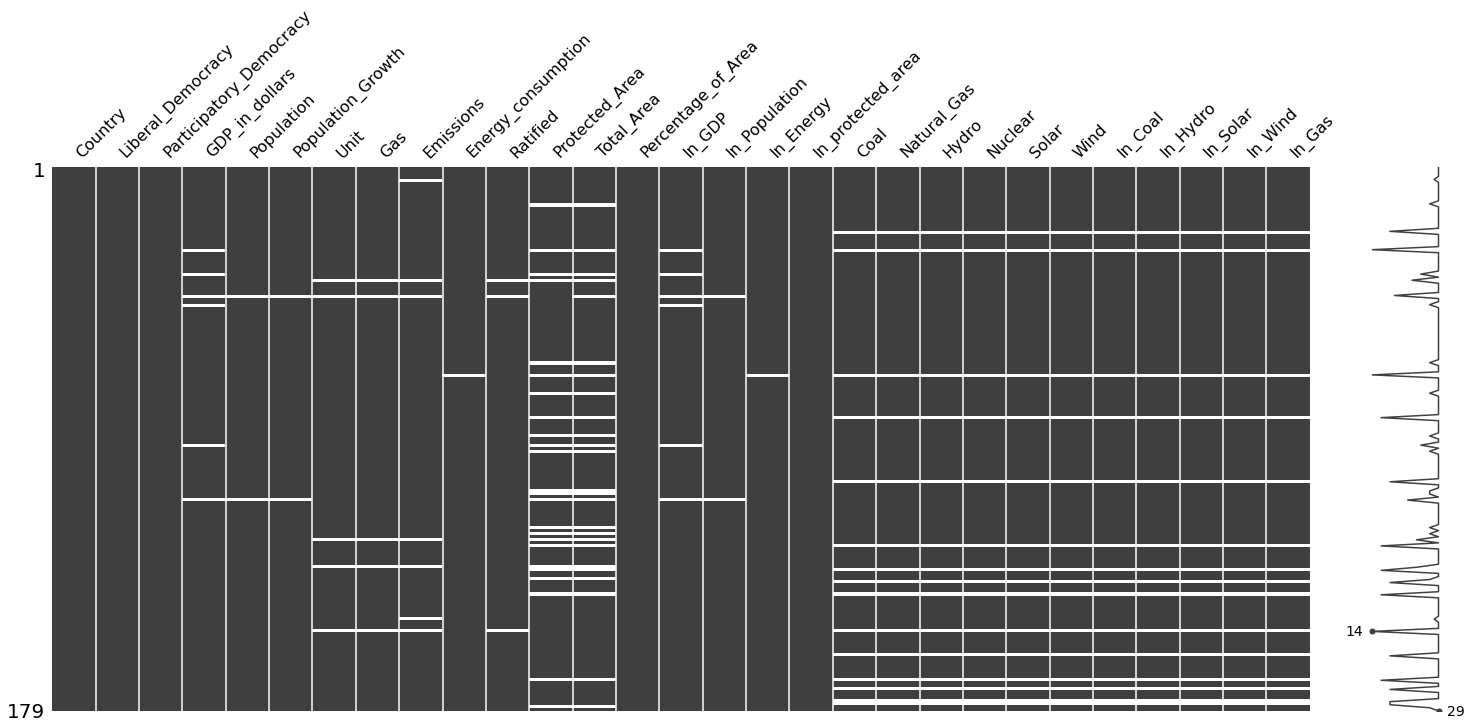

In [343]:
## Logging the required variables 
Model_data['ln_GDP'] = np.log(Model_data['GDP_in_dollars'] + 1)
Model_data['ln_Population'] = np.log(Model_data['Population'] + 1)
Model_data['ln_Energy'] = np.log(Model_data['Energy_consumption'] + 1)
Model_data['ln_protected_area'] = np.log(Model_data['Percentage_of_Area'] + 1)
Model_data['ln_Coal'] = np.log(Model_data['Coal'] + 1)
Model_data['ln_Hydro'] = np.log(Model_data['Hydro'] + 1)
Model_data['ln_Gas'] = np.log(Model_data['Natural_Gas'] + 1)
Model_data['Emissions'] = np.log(Model_data['Emissions'] + 1)

miss.matrix(Model_data)

In [ ]:
## Converting the ratified variable to a dummy 
Model_data.Ratified = pd.Series(np.where(Model_data.Ratified == 'Yes', 1, 0),
          Model_data.index)

In [344]:
## Resplitting the data after choosing required predictors 
df = Model_data.copy()
df = df.dropna()
y = df['Emissions']
X = df[['Liberal_Democracy','ln_GDP', 'ln_Population', 'Ratified', 'Population_Growth', \
        'ln_protected_area', 'ln_Energy', 'ln_Coal', 'ln_Gas', 'ln_Hydro']]

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1)


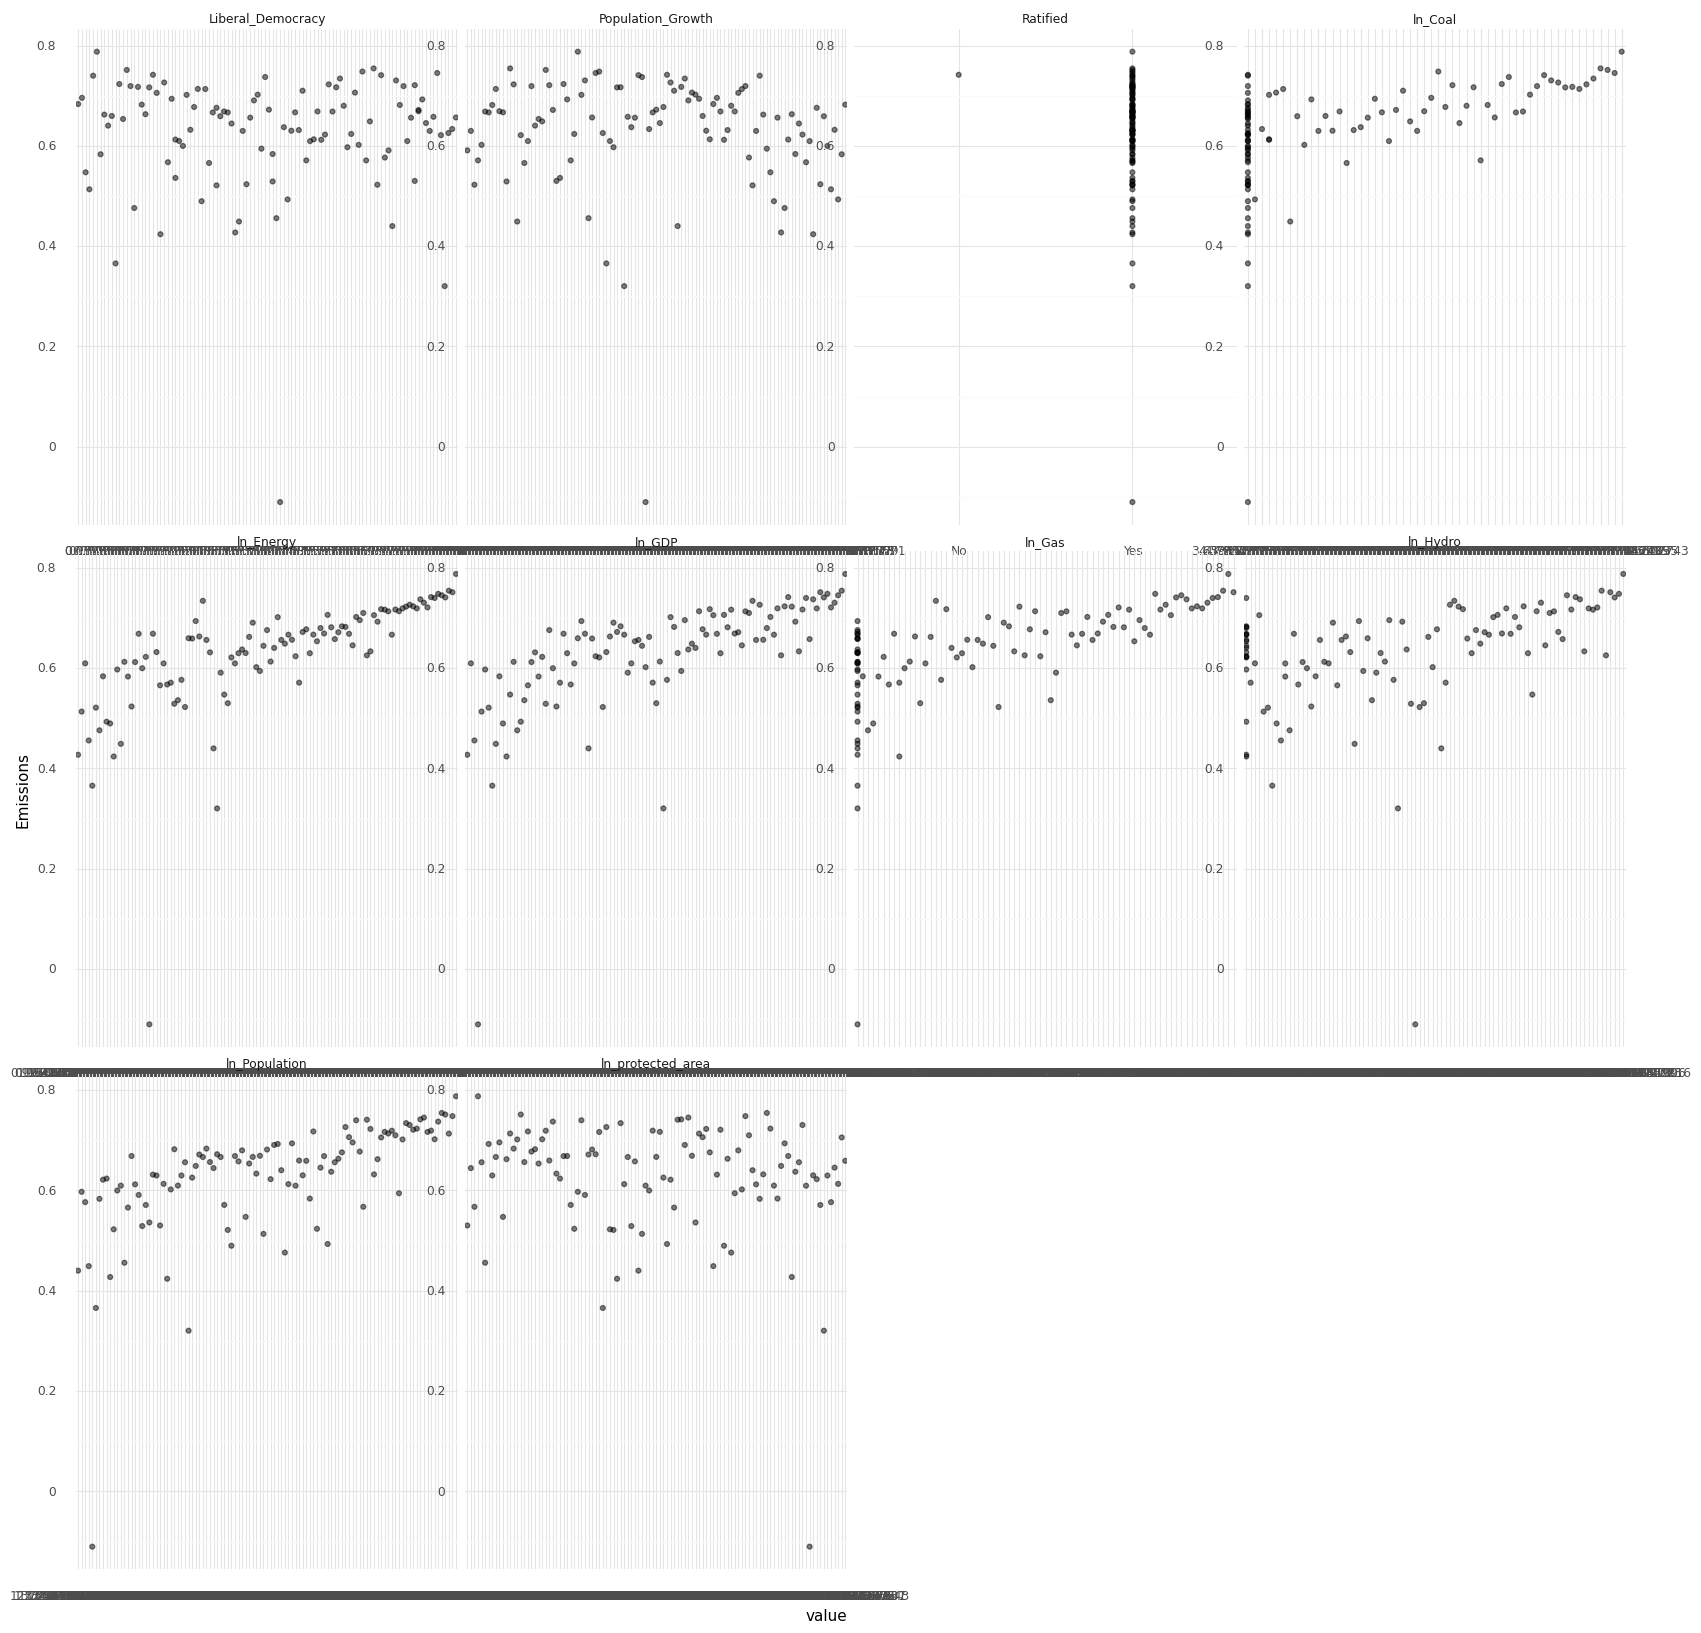

<ggplot: (381944311)>

In [345]:
## Plotting the relation of predictors with outcome variable 
D = train_X.copy()
D['Emissions'] = train_y

(
    ggplot(D.melt(id_vars=["Emissions"]),
           aes(x="value",y="Emissions"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (20,20))
    
)    

<AxesSubplot:>

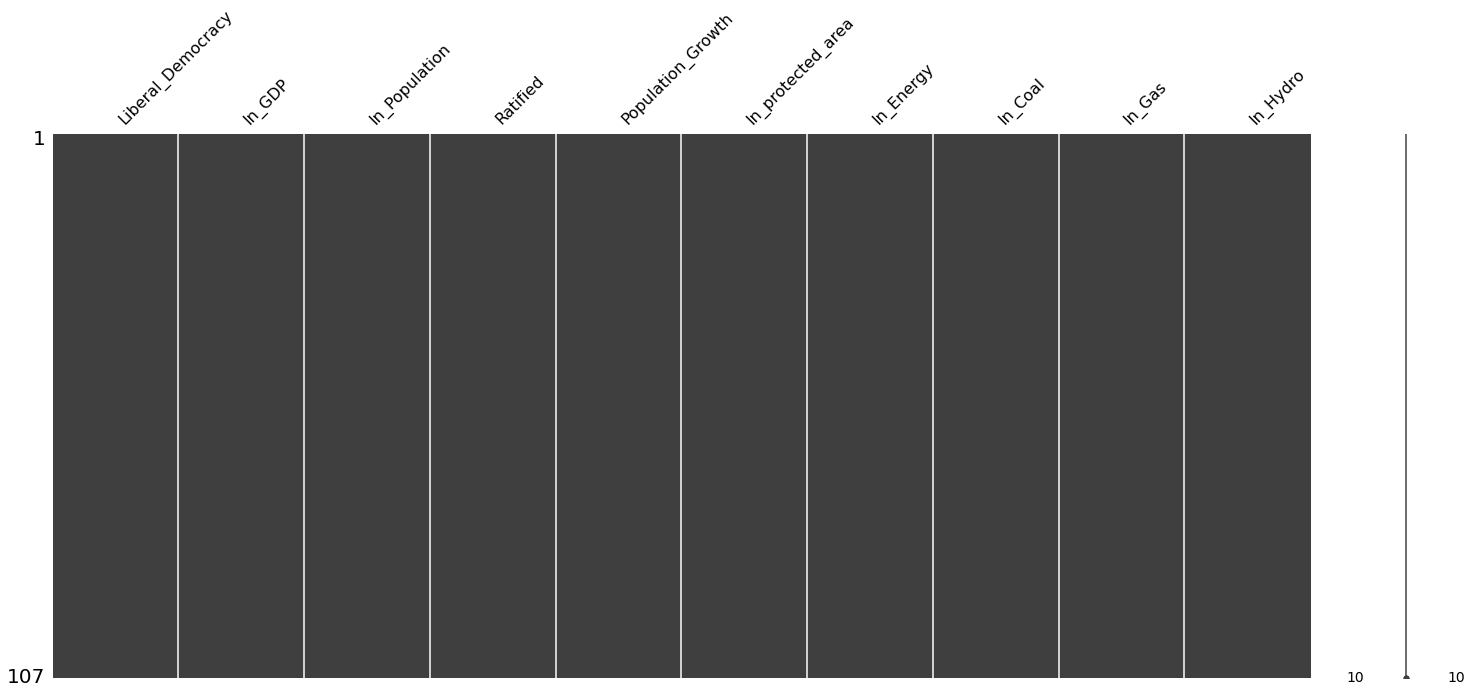

In [346]:
## Visualizing the missing values in the training set 
miss.matrix(train_X)

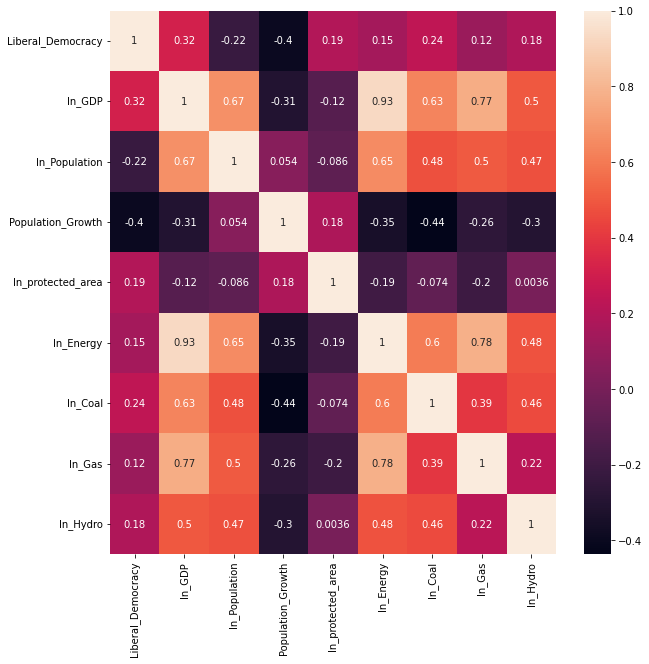

In [347]:
## Visualizing the correlation matrix 
train_corr = train_X.corr()
plt.figure(figsize = (10,10))
ax = sns.heatmap(train_corr, annot = True)

In [349]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Specifying the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['Liberal_Democracy', 'Population_Growth', 'ln_Population', 'ln_protected_area', 'ln_Energy', 'ln_Gas', 'ln_Coal', 'ln_Hydro'])])


# (3) Creating the model pipeline  
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specifying the models and their repsective tuning parameters. 

search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3,4],
     'model__n_estimators':[500,1000,1500],
     'model__max_features' : [1,2,3,4]}
]


# (5) Putting it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fitting the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Liberal_Democracy',
                                                                          'Population_Growth',
                                                                          'ln_Population',
                                                                          'ln_protected_area',
                                                                          'ln_Energy',
                                                                          'ln_Gas',
                                                                          'ln_Coal',
                                                                          'ln

<h2> Model Results </h2> 
<font size = 3 face = "Verdana">
    <p> After running various models by implementing GridSearch and Pipeline, the following results were obtained : 

In [350]:
search.best_score_ ##neg_mean_squared_error

-0.007060689260707864

In [351]:
## The best performing model 
search.best_params_

{'model': RandomForestRegressor(max_depth=4, max_features=2, n_estimators=500),
 'model__max_depth': 4,
 'model__max_features': 2,
 'model__n_estimators': 500}

In [352]:
mod = search.best_estimator_ ## Getting the best model 

In [353]:
## Mean squred error on test data
pred_y = search.predict(test_X)
m.mean_squared_error(test_y, pred_y)

0.0032304126039981087

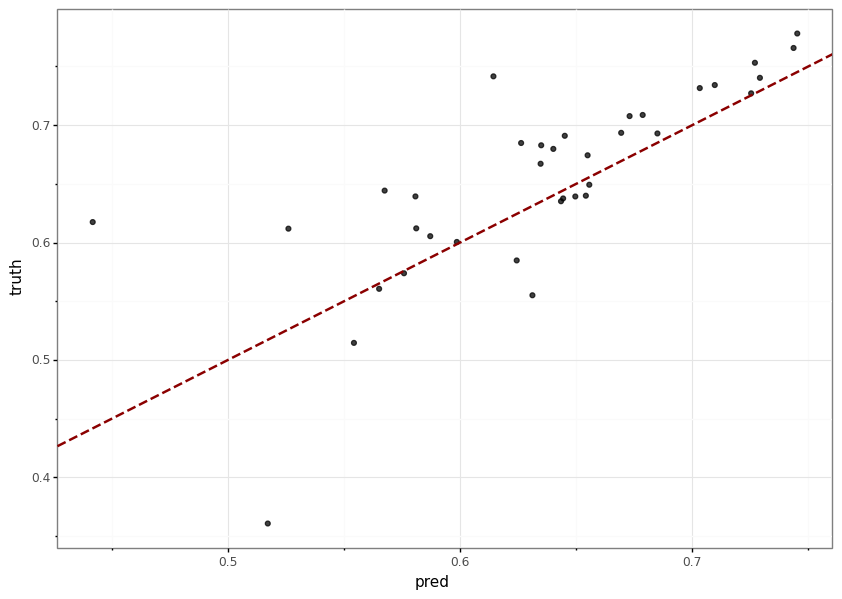

<ggplot: (382431404)>

In [354]:
### Plotting the predicted and actual values from model 
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)


## Interpretable Data Analysis

In [355]:
## Computing permutation importance 
vi = permutation_importance(mod,train_X,train_y,n_repeats= 25)

In [356]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,ln_Population,0.232244,0.049805,0.132635,0.331854
1,ln_Energy,0.210503,0.047542,0.115418,0.305587
2,ln_Gas,0.115072,0.034233,0.046605,0.183539
3,ln_protected_area,0.091500,0.024258,0.042985,0.140016
4,ln_Hydro,0.068076,0.019090,0.029896,0.106257
5,ln_Coal,0.050358,0.021244,0.007870,0.092846
6,Population_Growth,0.041715,0.009714,0.022286,0.061143
7,Liberal_Democracy,0.040468,0.011917,0.016634,0.064301
8,ln_GDP,0.000000,0.000000,0.000000,0.000000
9,Ratified,0.000000,0.000000,0.000000,0.000000


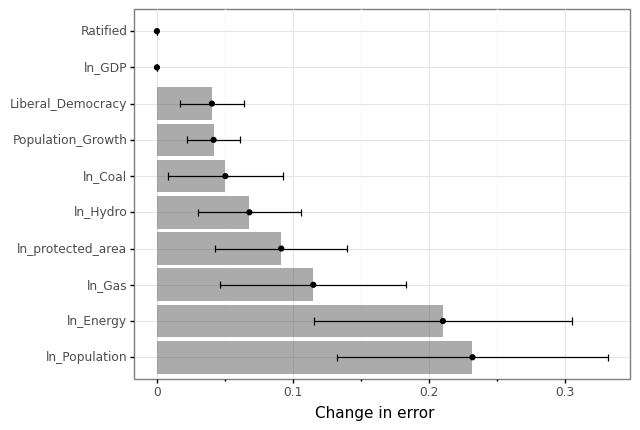

<ggplot: (366022807)>

In [357]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Change in error",x="")
)

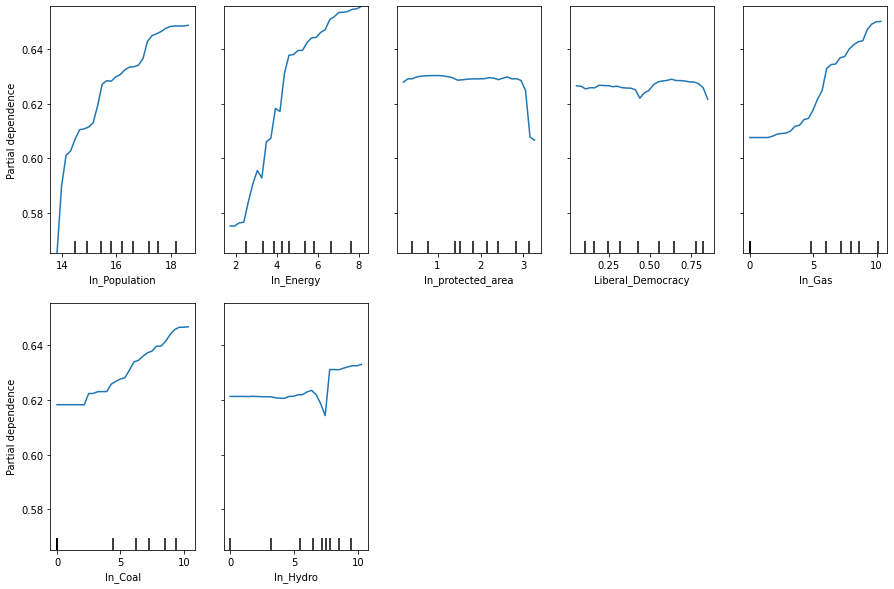

In [360]:
## Plottting Partial Dependecy Plots 
# Target specific features
features = ['ln_Population','ln_Energy','ln_protected_area','Liberal_Democracy', 'ln_Gas', 'ln_Coal', 'ln_Hydro']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 10))
display = plot_partial_dependence(
    mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

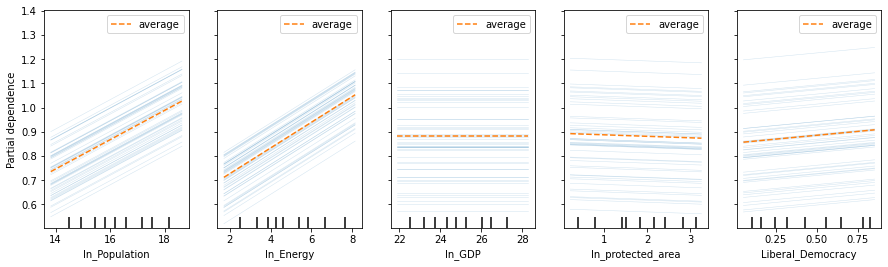

In [310]:
### Plotting the ICE graphs 
features = ['ln_Population','ln_Energy','ln_GDP','ln_protected_area','Liberal_Democracy']
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    mod,
    train_X,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)
